In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *


# Use English stemmer.
word_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
from gensim.models.keyedvectors import KeyedVectors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install keras==2.1.5

     |████████████████████████████████| 334 kB 2.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
real_news_df = pd.read_csv('sample_data/8000-1.csv')
fake_news_df = pd.read_csv('sample_data/fake_news_dataset_csv.csv', encoding= 'unicode_escape').dropna()
#real_news_df = real_news_df.rename(columns={"headline": "Article"})

In [ ]:
real_news_df['real_fact'] = 1
fake_news_df['real_fact'] = 0
print(real_news_df.shape)
print(fake_news_df.shape)

(8799, 6)
(8810, 6)


# Data cleaning

In [ ]:
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase



def get_cleaned_data(input_data, mode='df'):
  stop = stopwords.words('english')
  
  input_df = ''
  
  if mode != 'df':
      input_df = pd.DataFrame([input_data], columns=['Article'])
  else:
      input_df = input_data
      
  #lowercase the text
  input_df['Article'] = input_df['Article'].str.lower()
  
  input_df['Article'] = input_df['Article'].apply(lambda elem: decontracted(elem))
  
  #remove special characters
  input_df['Article'] = input_df['Article'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
  
  # remove numbers
  input_df['Article'] = input_df['Article'].apply(lambda elem: re.sub(r"\d+", "", elem))
  
  #remove stopwords
  input_df['Article'] = input_df['Article'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in (stop)]))
  
  #stemming, changes the word to root form
#     input_df['text'] = input_df['text'].apply(lambda words: [word_stemmer.stem(word) for word in words])
  
  #lemmatization, same as stemmer, but language corpus is used to fetch the root form, so resulting words make sense
#     more description @ https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
  input_df['Article'] = input_df['Article'].apply(lambda words: (wordnet_lemmatizer.lemmatize(words)))
#     print(input_df.head(3))
  
  return input_df


In [ ]:
import nltk
nltk.download('wordnet')

fake_news_df = get_cleaned_data(fake_news_df)
real_news_df = get_cleaned_data(real_news_df)
news_data_df = pd.concat([real_news_df, fake_news_df], ignore_index = True)
print(news_data_df.shape)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
(17609, 9)


In [ ]:
news_data_df

In [ ]:
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2


x_train,x_test,y_train,y_test = train_test_split(news_data_df.Article,news_data_df.real_fact,random_state = 42, test_size=VALIDATION_SPLIT, shuffle=True)

# Vectorize the text samples into a 2D integer tensor

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

tokenizer.fit_on_texts(x_train)

# Transforms each text in texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
# sequences = tokenizer.texts_to_sequences(news_data_df.text)
tokenized_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found {} unique tokens. and {} lines '.format(len(word_index), len(X_train)))

Found 16951 unique tokens. and 14087 lines 


In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-09-18 21:07:50--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.69.214
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.69.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  34.9MB/s    in 46s     

2020-09-18 21:08:36 (34.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

def get_embeddings(path):
  # model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300', binary=True, limit=500000)
  wv_from_bin = KeyedVectors.load_word2vec_format(path, binary=True, limit=500000) 
  #extracting word vectors from google news vector
  embeddings_index = {}
  for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
      coefs = np.asarray(vector, dtype='float32')
      embeddings_index[word] = coefs

  return embeddings_index

embeddings_index = {}
embeddings_index = get_embeddings('/root/input/GoogleNews-vectors-negative300.bin.gz')
print('Found %s word vectors.' % len(embeddings_index))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Found 500000 word vectors.


# Preparing embedding matrix

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

# LSTM model

In [ ]:
def lstm_net1():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(LSTM(units=128 , return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#training an LSTM network
model2 = lstm_net1()

batch_size = 256
epochs = 8

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          5085600   
_________________________________________________________________
lstm (LSTM)                  (None, 500, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [ ]:
history = model2.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
56/56 [==============================] - 465s 8s/step - loss: 0.4641 - accuracy: 0.7728 - val_loss: 0.3340 - val_accuracy: 0.8668
Epoch 2/8
56/56 [==============================] - 589s 11s/step - loss: 0.3149 - accuracy: 0.8655 - val_loss: 0.2975 - val_accuracy: 0.8739
Epoch 3/8
56/56 [==============================] - 660s 12s/step - loss: 0.2769 - accuracy: 0.8856 - val_loss: 0.2793 - val_accuracy: 0.8822
Epoch 4/8
56/56 [==============================] - 720s 13s/step - loss: 0.2474 - accuracy: 0.9006 - val_loss: 0.3022 - val_accuracy: 0.8705
Epoch 5/8
56/56 [==============================] - 725s 13s/step - loss: 0.2172 - accuracy: 0.9167 - val_loss: 0.2575 - val_accuracy: 0.8986
Epoch 6/8
56/56 [==============================] - 745s 13s/step - loss: 0.1911 - accuracy: 0.9274 - val_loss: 0.2849 - val_accuracy: 0.8807
Epoch 7/8
56/56 [==============================] - 758s 14s/step - loss: 0.1902 - accuracy: 0.9280 - val_loss: 0.2441 - val_accuracy: 0.9018
Epoch 8/8
56/5

# LSTM Confusion Matrix

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


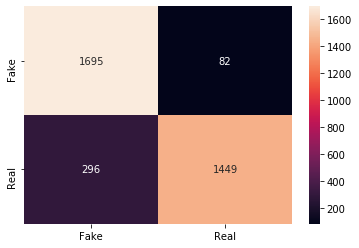

In [ ]:
pred = model2.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

In [ ]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, pred)
print("AUC score is ", auc_score)

AUC score is  0.8921136521583494


In [ ]:
from sklearn.metrics import f1_score

F1_score = f1_score(y_test, pred, average='macro')
print("F1 score is", F1_score)

F1 score is 0.8921484566389025


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score = accuracy_score(y_test, pred)
print("Acuracy is ", accuracy_score)

Acuracy is  0.8926746166950597


# Use 8800 data as training set

In [ ]:
print(type(y_train))

<class 'pandas.core.series.Series'>


In [ ]:
whole_train = news_data_df['Article']
whole_train_label = news_data_df['real_fact']

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

tokenizer.fit_on_texts(whole_train)

# Transforms each text in texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
# sequences = tokenizer.texts_to_sequences(news_data_df.text)
tokenized_train = tokenizer.texts_to_sequences(whole_train)
Whole_train = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found {} unique tokens. and {} lines '.format(len(word_index), len(Whole_train)))

Found 18830 unique tokens. and 17609 lines 


In [ ]:
history = model2.fit(Whole_train, whole_train_label, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
69/69 [==============================] - 792s 11s/step - loss: 0.6196 - accuracy: 0.6888 - val_loss: 0.4311 - val_accuracy: 0.8055
Epoch 2/8
69/69 [==============================] - 795s 12s/step - loss: 0.4690 - accuracy: 0.7760 - val_loss: 0.5089 - val_accuracy: 0.7516
Epoch 3/8
69/69 [==============================] - 896s 13s/step - loss: 0.4044 - accuracy: 0.8156 - val_loss: 0.5386 - val_accuracy: 0.7425
Epoch 4/8
69/69 [==============================] - 1083s 16s/step - loss: 0.3549 - accuracy: 0.8444 - val_loss: 0.5772 - val_accuracy: 0.7323
Epoch 5/8
69/69 [==============================] - 1290s 19s/step - loss: 0.3018 - accuracy: 0.8709 - val_loss: 0.6659 - val_accuracy: 0.7104
Epoch 6/8
69/69 [==============================] - 1689s 24s/step - loss: 0.2643 - accuracy: 0.8881 - val_loss: 0.6911 - val_accuracy: 0.7195
Epoch 7/8
69/69 [==============================] - 905s 13s/step - loss: 0.2299 - accuracy: 0.9060 - val_loss: 0.7589 - val_accuracy: 0.7022
Epoch 8/8


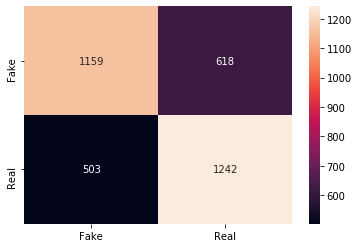

In [ ]:
pred = model2.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

In [ ]:
print(whole_train.shape)

(17609,)


In [ ]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, pred)
print("AUC score is ", auc_score)

AUC score is  0.6819853492493224


In [ ]:
from sklearn.metrics import f1_score

F1_score = f1_score(y_test, pred, average='macro')
print("F1 score is", F1_score)

F1 score is 0.6815380725051916


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score = accuracy_score(y_test, pred)
print("Acuracy is ", accuracy_score)

Acuracy is  0.6817149346961954


# **CNN**

In [ ]:
def cnn_net1():
  model = Sequential()

  #Non-trainable embeddidng layer
  model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  
  model.add(Dropout(0.2))
  model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2))
  model.add(Dense(units = 250 , activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model


def get_pred_output(text_to_check):
  sequences = tokenizer.texts_to_sequences([text_to_check])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  predicted_val = model.predict_classes(data)
#     predicted_val = model.predict(data)    
#     if predicted_val.max() > 0.7:
#         output = 1
#     else:
#         output = 0
  return predicted_val

In [ ]:
# train a 1D convnet with global maxpooling
model_1 = cnn_net1()

batch_size = 256
epochs = 8

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          5085600   
_________________________________________________________________
dropout (Dropout)            (None, 500, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 497, 128)          153728    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               32250     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [ ]:
history = model_1.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
56/56 [==============================] - 105s 2s/step - loss: 0.5246 - accuracy: 0.7420 - val_loss: 0.3759 - val_accuracy: 0.8277
Epoch 2/8
56/56 [==============================] - 105s 2s/step - loss: 0.3483 - accuracy: 0.8477 - val_loss: 0.3336 - val_accuracy: 0.8569
Epoch 3/8
56/56 [==============================] - 105s 2s/step - loss: 0.2965 - accuracy: 0.8752 - val_loss: 0.2814 - val_accuracy: 0.8805
Epoch 4/8
56/56 [==============================] - 105s 2s/step - loss: 0.2374 - accuracy: 0.9010 - val_loss: 0.2842 - val_accuracy: 0.8816
Epoch 5/8
56/56 [==============================] - 108s 2s/step - loss: 0.2173 - accuracy: 0.9129 - val_loss: 0.2471 - val_accuracy: 0.9020
Epoch 6/8
56/56 [==============================] - 105s 2s/step - loss: 0.1841 - accuracy: 0.9262 - val_loss: 0.2479 - val_accuracy: 0.8986
Epoch 7/8
56/56 [==============================] - 105s 2s/step - loss: 0.1645 - accuracy: 0.9357 - val_loss: 0.2355 - val_accuracy: 0.9043
Epoch 8/8
56/56 [===

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


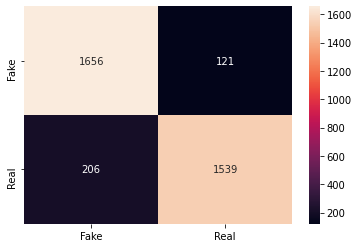

In [ ]:
pred = model_1.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

auc_score = roc_auc_score(y_test, pred)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, pred, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, pred)
print("Acuracy is ", accuracy_score)

AUC score is  0.906928066845864
F1 score is 0.9070524530508333
Acuracy is  0.9071550255536627


# **SVM**

In [ ]:
cf_matrix = confusion_matrix(y_test,svm_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

In [ ]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)


auc_score = roc_auc_score(y_test, predictions_SVM)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, predictions_SVM, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, predictions_SVM)
print("Acuracy is ", accuracy_score)

AUC score is  0.615212851897777
F1 score is 0.61482292536295
Acuracy is  0.6155593412833618


# **Naive Bayes**

In [ ]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)

auc_score = roc_auc_score(y_test, predictions_NB)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, predictions_NB, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, predictions_NB)
print("Acuracy is ", accuracy_score)

AUC score is  0.5764770475335108
F1 score is 0.5138666355408052
Acuracy is  0.5732538330494037


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_log =  clf.predict(X_test)

auc_score = roc_auc_score(y_test, pred_log)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, pred_log, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, pred_log)
print("Acuracy is ", accuracy_score)

AUC score is  0.5749126453425093
F1 score is 0.5057593237547798
Acuracy is  0.5715502555366269


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

neigh = KNeighborsClassifier(n_neighbors=3)
clf = neigh.fit(X_train, y_train)
pred_knn =  clf.predict(X_test)


In [ ]:
auc_score = roc_auc_score(y_test, pred_knn)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, pred_knn, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, pred_knn)
print("Acuracy is ", accuracy_score)

AUC score is  0.5937019186581809
F1 score is 0.5936872969185022
Acuracy is  0.5936967632027257


## **DBN**

In [ ]:
% pip install git+git://github.com/albertbup/deep-belief-network.git

  Cloning git://github.com/albertbup/deep-belief-network.git to /tmp/pip-req-build-38i9x6be
  Running command git clone -q git://github.com/albertbup/deep-belief-network.git /tmp/pip-req-build-38i9x6be
  Created wheel for deep-belief-network: filename=deep_belief_network-1.0.3-cp36-none-any.whl size=13464 sha256=f3d785ae31a65305fdf4bb28fbd33934403b23c4c7671e922a37c12e92eaa453
  Stored in directory: /tmp/pip-ephem-wheel-cache-5rqisz0h/wheels/29/6d/3b/6a50cf42a32bdfaa903b17832d60d8d3e5dc4b0fd02ae8acaf
Successfully built deep-belief-network


In [ ]:
from dbn import SupervisedDBNClassification
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# Training
classifier = SupervisedDBNClassification(hidden_layers_structure=[256, 256], learning_rate_rbm=0.05, learning_rate=0.1, n_epochs_rbm=10, n_iter_backprop=100, batch_size=32, activation_function='relu', dropout_p=0.2)
classifier.fit(X_train, y_train)

# Test
pred_dbn = classifier.predict(X_test)


auc_score = roc_auc_score(y_test, pred_dbn)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, pred_dbn, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, pred_dbn)
print("Acuracy is ", accuracy_score)


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 56254806.383125
>> Epoch 2 finished 	RBM Reconstruction error 56254820.657007
>> Epoch 3 finished 	RBM Reconstruction error 56254443.958099
>> Epoch 4 finished 	RBM Reconstruction error 56254085.293391
>> Epoch 5 finished 	RBM Reconstruction error 56235574.841113
>> Epoch 6 finished 	RBM Reconstruction error 56236024.392956
>> Epoch 7 finished 	RBM Reconstruction error 56234460.174612
>> Epoch 8 finished 	RBM Reconstruction error 56235458.919449
>> Epoch 9 finished 	RBM Reconstruction error 56234296.436590
>> Epoch 10 finished 	RBM Reconstruction error 56232033.393680
>> Epoch 1 finished 	RBM Reconstruction error 0.000000
>> Epoch 2 finished 	RBM Reconstruction error 0.000000
>> Epoch 3 finished 	RBM Reconstruction error 0.000000
>> Epoch 4 finished 	RBM Reconstruction error 0.000000
>> Epoch 5 finished 	RBM Reconstruction error 0.000000
>> Epoch 6 finished 	RBM Reconstruction error 0.000000
>> Epoch 7 finished 	R